<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 40px;'>🚀</span>
  <span style='font-weight: normal; font-size: 32px; color: #3AB77A;'>Desafio Creditas -</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'> Cientista de Dados Pleno</span>
</div>
<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-weight: normal; font-size: 19px; color: #F;'>Etapa 6: Hypertunning modelo</span>
</div>

<br><br>

<div style='color: #3AB77A; text-align: center; font-size: 28px; font-weight: bold'>
  <p>
    Conteúdo desse Notebook
  </p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Analise dos splits para treinamento com features selecionadas</p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Treinamento faseado para implicação do range no Hypertunning</p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Checagem de Leakage nos splits e com as features</p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Analise dos resultados do modelo</p>
</div>

In [1]:
import yaml
with open('../utils/variables.yml', 'r') as file:
    variables = yaml.safe_load(file)

In [2]:
import pandas as pd
import numpy as np
import sys, os
sys.path.insert(0, os.path.abspath(".."))

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split        
from lightgbm import LGBMClassifier, early_stopping 
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

from utils.plot_utils import plotter as ptz

pd.set_option('display.max_columns', 500)
from utils.eda_utils import (
    get_all_information,
    StartEda
)

from utils.feature_utils import (
    ModelUtils,
)

from utils.model_utils import (
    create_pipeline,
    training_fased,
    plot_feature_importance,
    check_leakage,
    plot_precision_recall_and_roc,
    plot_dist,
    plot_confusion_matrix,
    plot_feature_importance,
    plot_shapley,
)

from utils.plot_utils import (
    plot_result_metric
)

import warnings
warnings.filterwarnings("ignore")

# Dessa vez utilizando a base bronze
df = pd.read_csv('../data/bronze_dataset.csv')
get_all_information(df=df, column_filter='pre_approved', column_target='sent_to_analysis')
df = df[df['pre_approved'] == 1].drop(['pre_approved'],axis=1)

# Realizando os processos de input de NA baseado na regra identificada anteriormente
control = StartEda(df=df, direct_input_cols=['collateral_debt','informed_restriction'])
df = control.df

df.drop([
    'city',
    'auto_model',
    'informed_purpose'
],axis=1,inplace=True)

# Analisando a problematica dos dados #
De todos os casos nessa base, reprovados temos 19820
De todos os casos nessa base, pré-aprovado temos 14976
Que realmente aprovamos para a analise de crédito foram 3262
Que realmente reprovamos para a analise de crédito foram 11714


In [3]:
columns_ignore= [
 'dishonored_checks','expired_debts','banking_debts','commercial_debts','protests','informed_restriction','form_completed','verified_restriction'
]

columns_without = [
 'dishonored_checks','expired_debts','banking_debts','commercial_debts','protests','informed_restriction','form_completed','verified_restriction',
]

education_order = [
'Analfabeto, inclusive o que, embora tenha recebido instrução, não se alfabetizou.',
'Até a 4ª série incompleta do ensino fundamental (antigo 1º grau ou primário), que se tenha alfabetizado sem ter freqüentado escola regular.',
'4ª série completa do ensino fundamental (antigo 1º grau ou primário).',
'Da 5ª à 8ª série do ensino fundamental (antigo 1º grau ou ginásio).',
'Ensino fundamental completo (antigo 1º grau ou primário e ginasial).',
'Ensino médio incompleto (antigo 2º grau, secundário ou colegial).',
'Ensino médio completo (antigo 2º grau, secundário ou colegial).',
'Educação superior incompleta.',
'Educação superior completa'
]

model_prep = ModelUtils(
    df=df,
    target='sent_to_analysis',
    columns_ignore=columns_ignore,
    columns_without=columns_without
)

X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test = model_prep.start_pipeline()

X_train_transformed = X_train_transformed[variables['columns_keepers']]
X_val_transformed = X_val_transformed[variables['columns_keepers']]
X_test_transformed = X_test_transformed[variables['columns_keepers']]

model_prep.pipe_prep[0]

Ignorando essas colunas tanto para OneHot quanto para Numerical: ['dishonored_checks', 'expired_debts', 'banking_debts', 'commercial_debts', 'protests', 'informed_restriction', 'form_completed', 'verified_restriction']
['id', 'age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 'IdadeCarro', 'isSP', 'QtdSalariosMinimos', 'ValorGarantiaRealAuto', 'PropLoanGarantiaVeiculo', 'PropLoanReal', 'PropLoanMonthlyIncome', 'numero_de_empresas_atuantes', 'PropIncomeSalarioMedioMensal', 'ClassPurpose']
['channel', 'landing_page_product', 'gender', 'education_level', 'ClassMarca', 'regiao']
DataFrames criados sendo numericas:17, one_hot:6, ordinal:0
Pipelines criados, criando of FeatureUnion
[FeatureUnion] ...... (step 1 of 3) Processing pipe_num, total=   0.0s
[FeatureUnion] ...... (step 2 of 3) Processing pipe_hot, total=   0.0s
[FeatureUnion]  (step 3 of 3) Processing pipe_sem_mexer, total=   0.0s
18270.0 0.0 23000.0 24999.0
10.506162830680966 0.0 10.7

FeatureUnion(transformer_list=[('pipe_num',
                                Pipeline(steps=[('selector_numerical',
                                                 ColumnTransformer(transformers=[('filter_num_cols',
                                                                                  'passthrough',
                                                                                  array(['id', 'age', 'monthly_income', 'collateral_value', 'loan_amount',
       'collateral_debt', 'monthly_payment', 'IdadeCarro', 'isSP',
       'QtdSalariosMinimos', 'ValorGarantiaRealAuto',
       'PropLoanGarantiaVeiculo', 'PropLoan...
                                                 SimpleImputer(strategy='most_frequent')),
                                                ('OneHotEncoder', None)])),
                               ('pipe_sem_mexer',
                                Pipeline(steps=[('selector_one_hot',
                                                 ColumnTransformer(transformers=[('filter_ignore_cols',
                                                                                  'passthrough',
                                                                                  array(['dishonored_checks', 'expired_debts', 'banking_debts',
       'commercial_debts', 'protests', 'informed_restriction',
       'form_completed', 'verified_restriction'], dtype=object))]))]))],
             verbose=True)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Analise Data Drift: Checando sustentação das features</span>
</div>

<br>

######################
Label - 1: Significa o X_first
Label - 0: Significa o X_second
Threshold: Considerar acima de 0.33 como atenção.
######################


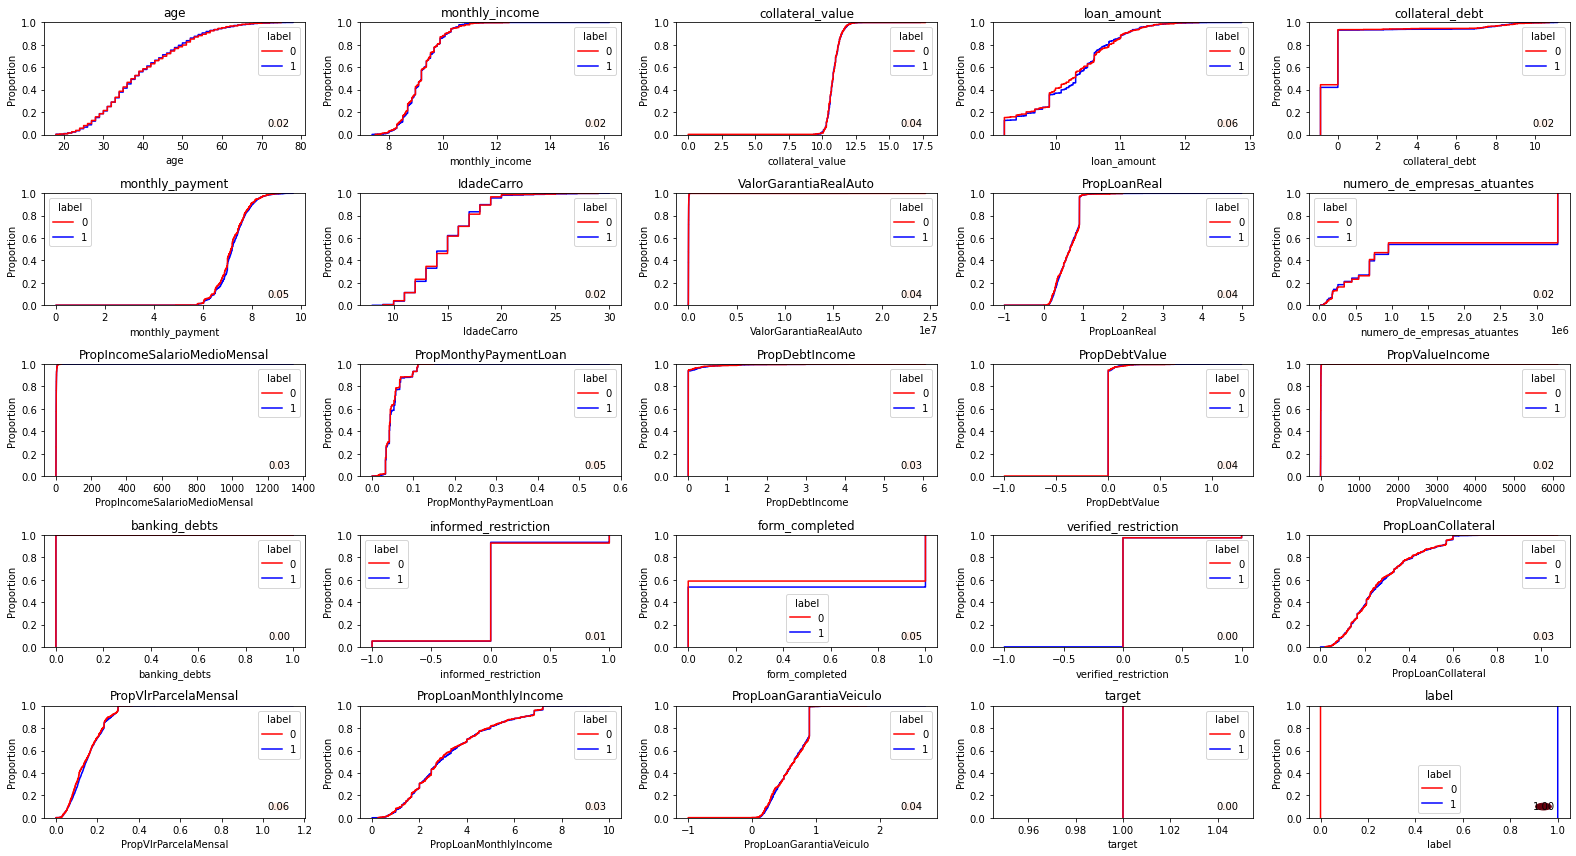

In [4]:
p = ptz()
p.plot_ecdf_splits(
    X_first=X_train_transformed.copy(),
    X_second=X_val_transformed.copy(),
    y_first=y_train,
    y_second=y_val,
    interest=1,
    figsize_to_plot=(22,12)
)

######################
Label - 1: Significa o X_first
Label - 0: Significa o X_second
Threshold: Considerar acima de 0.33 como atenção.
######################


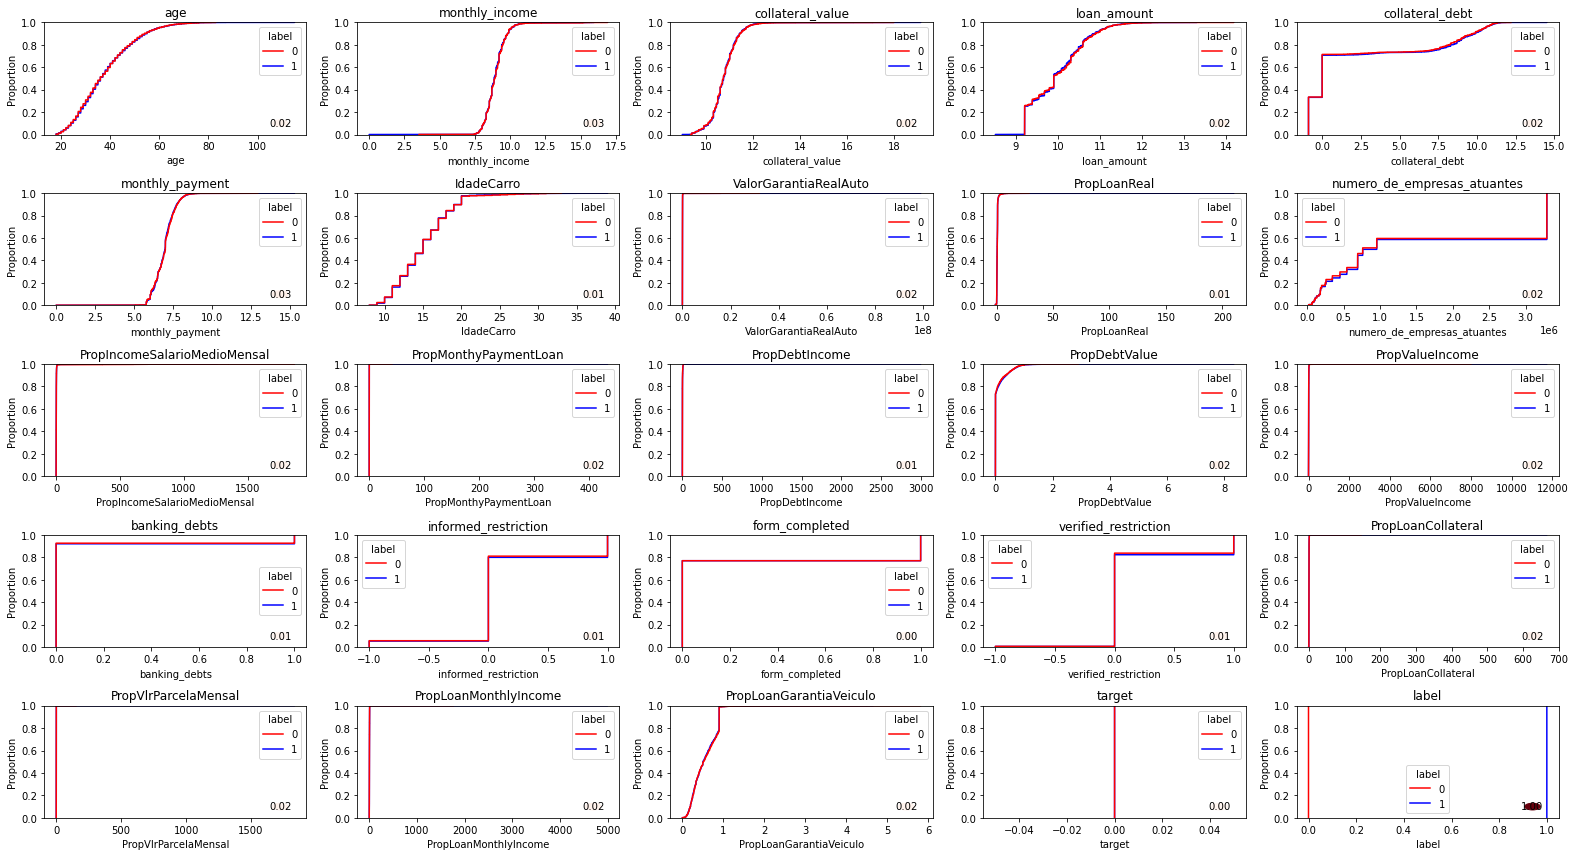

In [5]:
p = ptz()
p.plot_ecdf_splits(
    X_first=X_train_transformed.copy(),
    X_second=X_val_transformed.copy(),
    y_first=y_train,
    y_second=y_val,
    interest=0,
    figsize_to_plot=(22,12)
)

######################
Label - 1: Significa o X_first
Label - 0: Significa o X_second
Threshold: Considerar acima de 0.33 como atenção.
######################


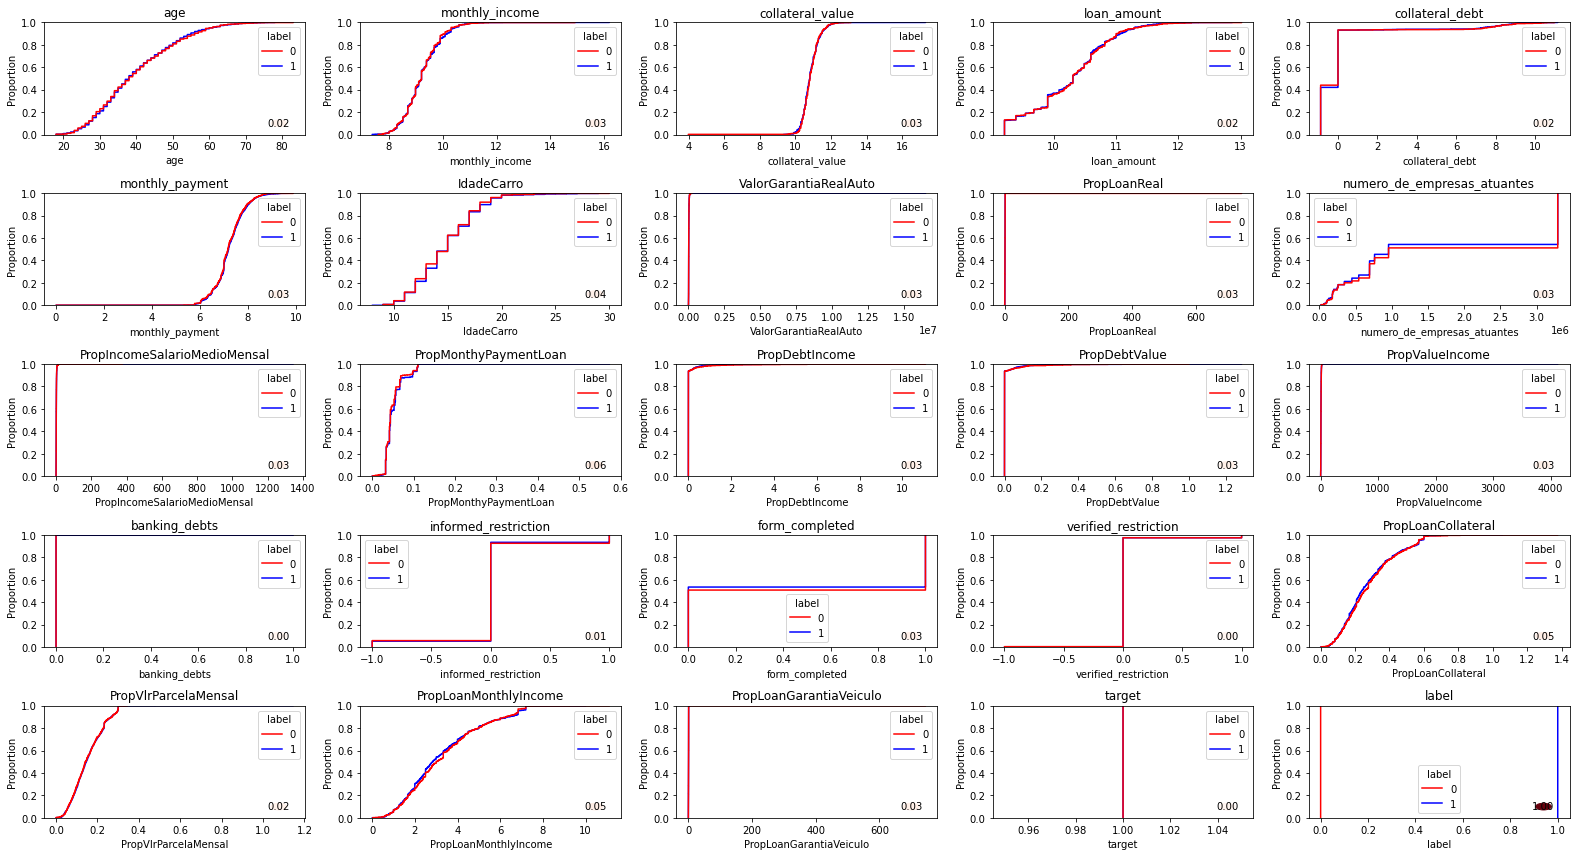

In [6]:
p = ptz()
p.plot_ecdf_splits(
    X_first=X_train_transformed.copy(),
    X_second=X_test_transformed.copy(),
    y_first=y_train,
    y_second=y_test,
    interest=1,
    figsize_to_plot=(22,12)
)

######################
Label - 1: Significa o X_first
Label - 0: Significa o X_second
Threshold: Considerar acima de 0.33 como atenção.
######################


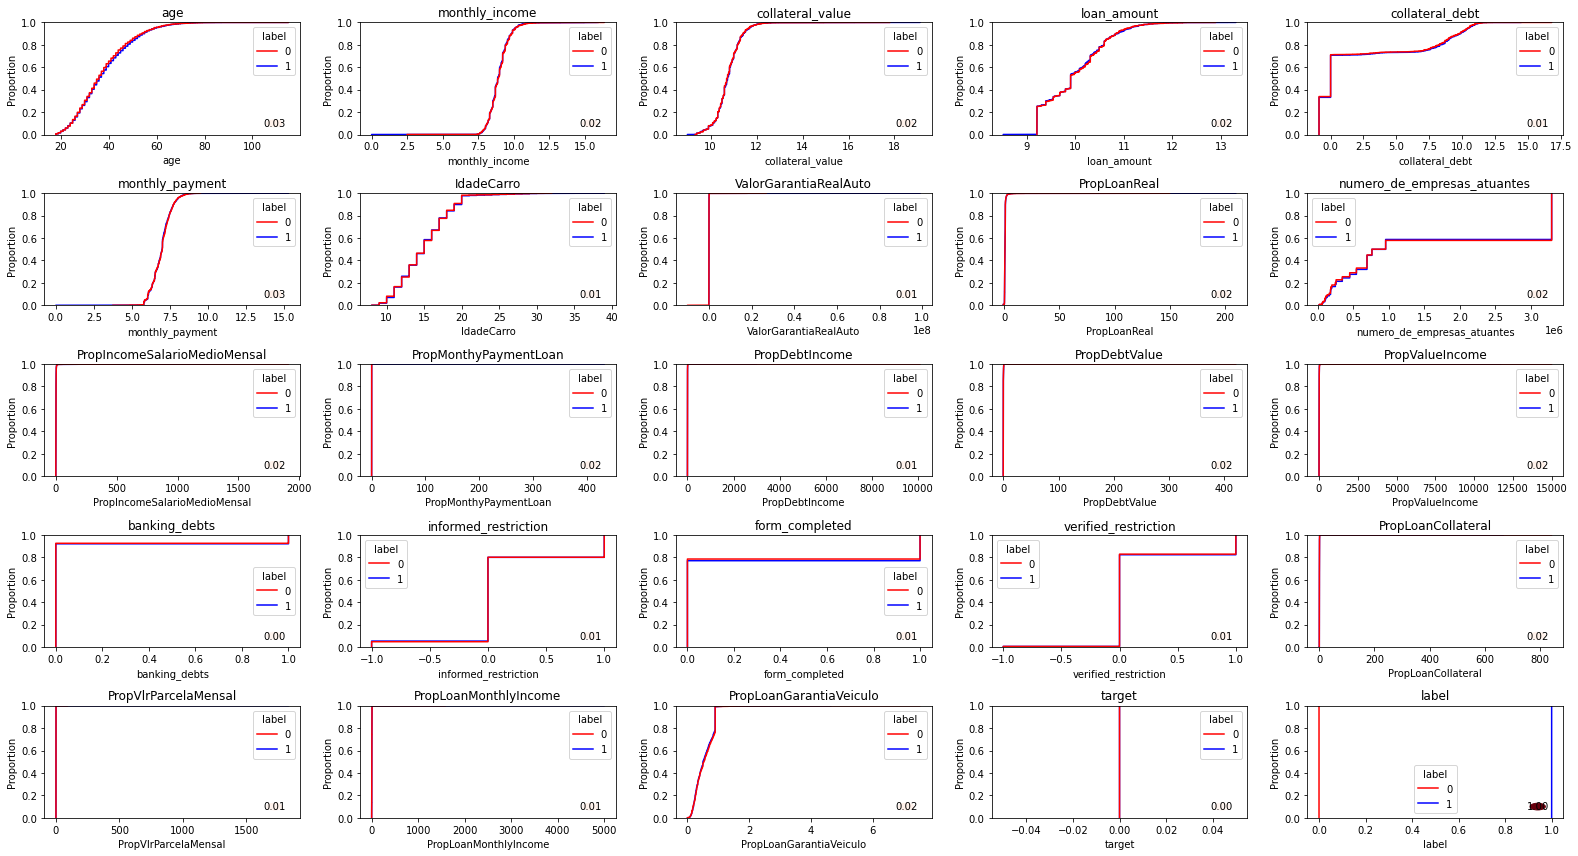

In [7]:
p = ptz()
p.plot_ecdf_splits(
    X_first=X_train_transformed.copy(),
    X_second=X_test_transformed.copy(),
    y_first=y_train,
    y_second=y_test,
    interest=0,
    figsize_to_plot=(22,12)
)

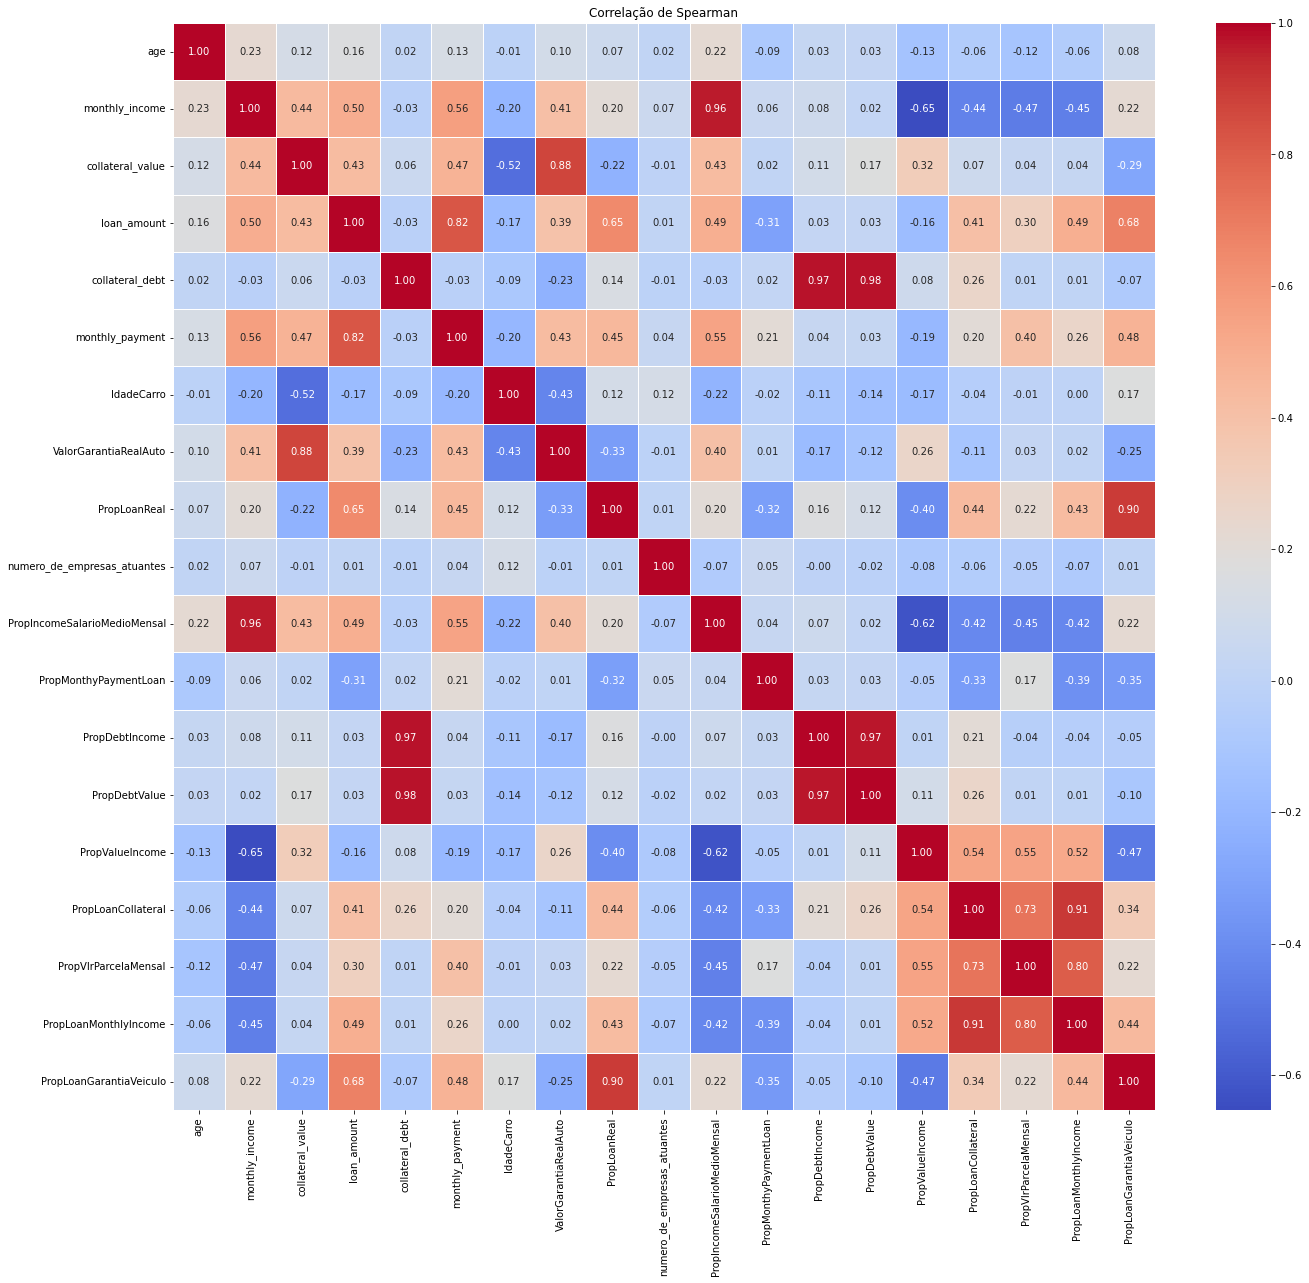

In [8]:
ptz.corrplot(df=X_train_transformed, figsize=(22,20))

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Model Development: Checando Data Leakage</span>
</div>

<br>

Ignorando essas colunas tanto para OneHot quanto para Numerical: ['banking_debts', 'informed_restriction', 'form_completed', 'verified_restriction']
['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 'IdadeCarro', 'ValorGarantiaRealAuto', 'PropLoanReal', 'numero_de_empresas_atuantes', 'PropIncomeSalarioMedioMensal', 'PropMonthyPaymentLoan', 'PropDebtIncome', 'PropDebtValue', 'PropValueIncome', 'PropLoanCollateral', 'PropVlrParcelaMensal', 'PropLoanMonthlyIncome', 'PropLoanGarantiaVeiculo']
[]
DataFrames criados sendo numericas:19, one_hot:0, ordinal:0
Pipelines criados, criando of FeatureUnion
Você possui 19 features com importância acima de 1.5%
Isso representa 83.0%
Você possui no total 23 features


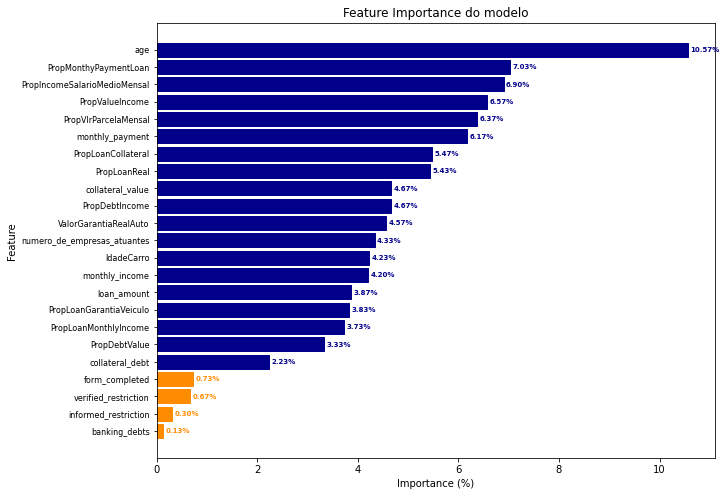

['form_completed',
 'verified_restriction',
 'informed_restriction',
 'banking_debts']

<Figure size 432x288 with 0 Axes>

In [4]:
check_leakage(
    X_train_transformed=X_train_transformed.copy(),
    X_val_transformed=X_val_transformed.copy(),
    columns_ignore=variables['columns_ignore'],
    columns_without=variables['columns_without']
)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Model Development: Treinamento faseado</span>
</div>

<br>

In [5]:
for col in [
    'banking_debts', 
    'informed_restriction', 
    'form_completed', 
    'verified_restriction'
]:
    X_train_transformed[col] = X_train_transformed[col].astype('int64')

In [6]:
pipe = create_pipeline(
    df=X_train_transformed,
    columns_ignore=variables['columns_ignore'],
    columns_include_without_transformation=variables['columns_without'],
    ordinal_order=None,
    numerical_scaler=None,
)

pipe_prep_features = pipe[0] ; pipe[0]

Ignorando essas colunas tanto para OneHot quanto para Numerical: ['banking_debts', 'informed_restriction', 'form_completed', 'verified_restriction']
['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 'IdadeCarro', 'ValorGarantiaRealAuto', 'PropLoanReal', 'numero_de_empresas_atuantes', 'PropIncomeSalarioMedioMensal', 'PropMonthyPaymentLoan', 'PropDebtIncome', 'PropDebtValue', 'PropValueIncome', 'PropLoanCollateral', 'PropVlrParcelaMensal', 'PropLoanMonthlyIncome', 'PropLoanGarantiaVeiculo']
[]
DataFrames criados sendo numericas:19, one_hot:0, ordinal:0
Pipelines criados, criando of FeatureUnion


FeatureUnion(transformer_list=[('pipe_num',
                                Pipeline(steps=[('selector_numerical',
                                                 ColumnTransformer(transformers=[('filter_num_cols',
                                                                                  'passthrough',
                                                                                  array(['age', 'monthly_income', 'collateral_value', 'loan_amount',
       'collateral_debt', 'monthly_payment', 'IdadeCarro',
       'ValorGarantiaRealAuto', 'PropLoanReal',
       'numero_de_empresas_atuantes', 'PropIncomeSalarioMedio...
       'PropLoanMonthlyIncome', 'PropLoanGarantiaVeiculo'], dtype=object))])),
                                                ('num_imputer',
                                                 SimpleImputer(strategy='median')),
                                                ('NumScaler', None)])),
                               ('pipe_sem_mexer',
                                Pipeline(steps=[('selector_one_hot',
                                                 ColumnTransformer(transformers=[('filter_ignore_cols',
                                                                                  'passthrough',
                                                                                  array(['banking_debts', 'informed_restriction', 'form_completed',
       'verified_restriction'], dtype=object))]))]))])

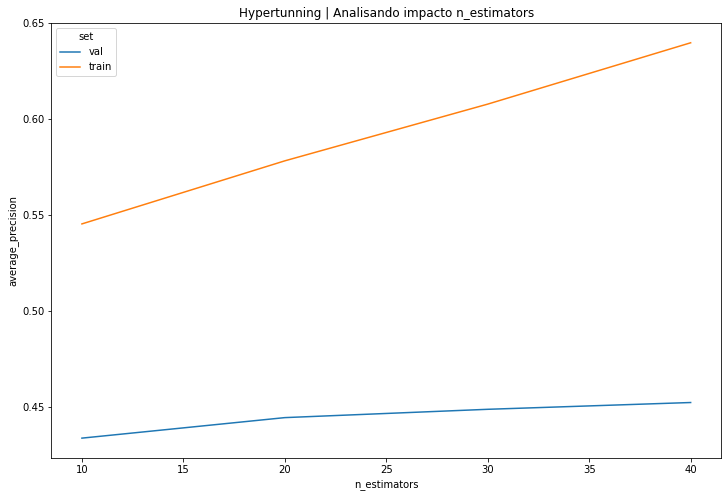

In [12]:
df_plot = training_fased(
    hyper_parameter='n_estimators',
    dict_parameters={
        'class_weight': 'balanced'
    },
    limit_down_range=10,
    limit_up_range=50,
    step=10,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42))
    ]),
    metric=average_precision_score,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

plot_result_metric(
    df_plot=df_plot,
    xlabel='n_estimators',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto n_estimators',
    huer='set'
)

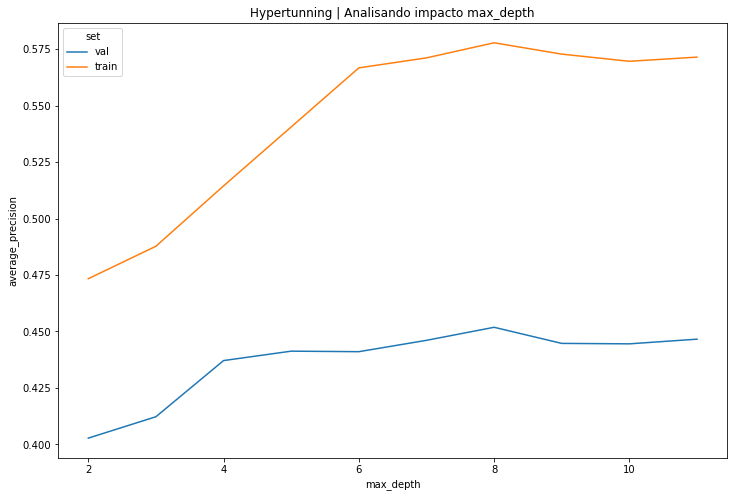

In [13]:
df_plot = training_fased(
    hyper_parameter='max_depth',
    dict_parameters={
        'n_estimators': 17,
        'class_weight': 'balanced'
    },
    limit_down_range=2,
    limit_up_range=12,
    step=1,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42, verbose=-1))
    ]),
    metric=average_precision_score,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

plot_result_metric(
    df_plot=df_plot,
    xlabel='max_depth',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto max_depth',
    huer='set'
)

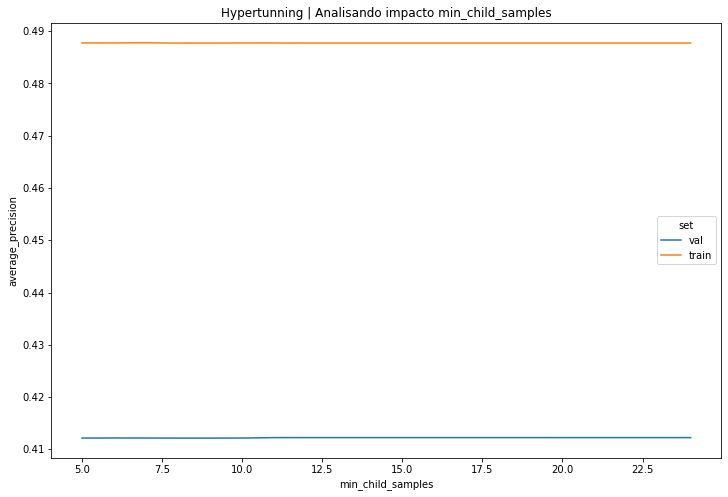

In [14]:
df_plot = training_fased(
    hyper_parameter='min_child_samples',
    dict_parameters={
        'n_estimators': 17,
        'max_depth': 3,
        'class_weight': 'balanced'
    },
    limit_down_range=5,
    limit_up_range=25,
    step=1,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42))
    ]),
    metric=average_precision_score,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

plot_result_metric(
    df_plot=df_plot,
    xlabel='min_child_samples',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto min_child_samples',
    huer='set'
)

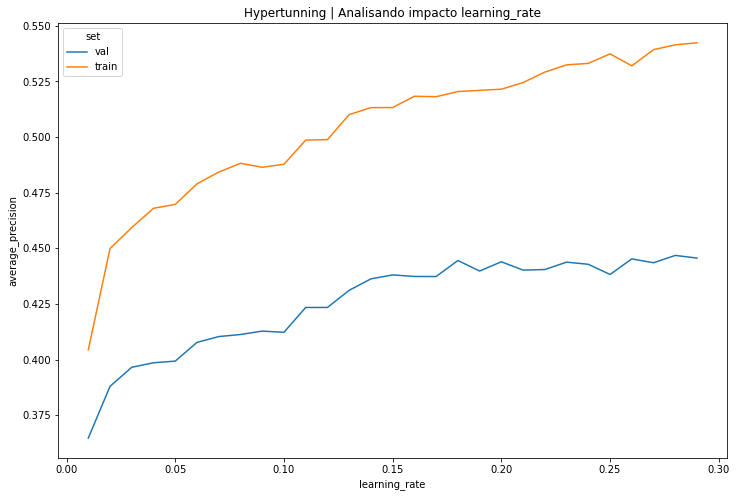

In [15]:
df_plot = training_fased(
    hyper_parameter='learning_rate',
    dict_parameters={
        'n_estimators': 17,
        'max_depth': 3,
        'min_child_samples': 22,
        'class_weight': 'balanced'
    },
    limit_down_range=0.01,
    limit_up_range=0.3,
    step=0.01,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42))
    ]),
    metric=average_precision_score,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

plot_result_metric(
    df_plot=df_plot,
    xlabel='learning_rate',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto learning_rate',
    huer='set'
)

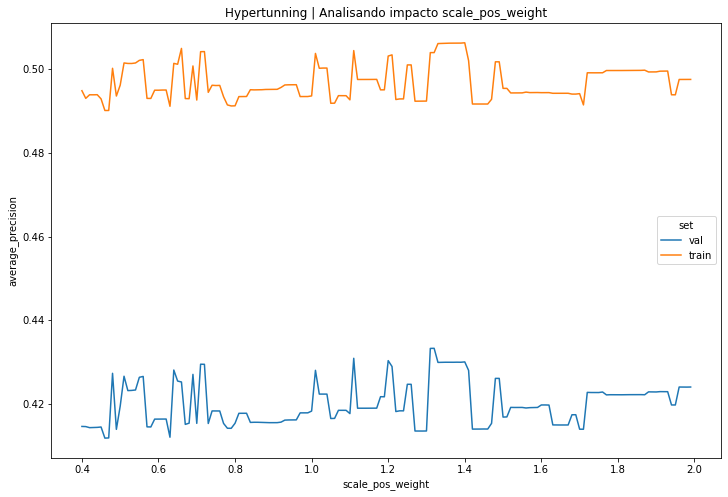

In [16]:
df_plot = training_fased(
    hyper_parameter='scale_pos_weight',
    dict_parameters={
        'n_estimators': 17,
        'max_depth': 3,
        'min_child_samples': 22,
        'learning_rate': 0.15,
        'boosting_type': 'dart',
        'class_weight': 'balanced'
    },
    limit_down_range=0.4,
    limit_up_range=2,
    step=0.01,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42))
    ]),
    metric=average_precision_score,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

plot_result_metric(
    df_plot=df_plot,
    xlabel='scale_pos_weight',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto scale_pos_weight',
    huer='set'
)

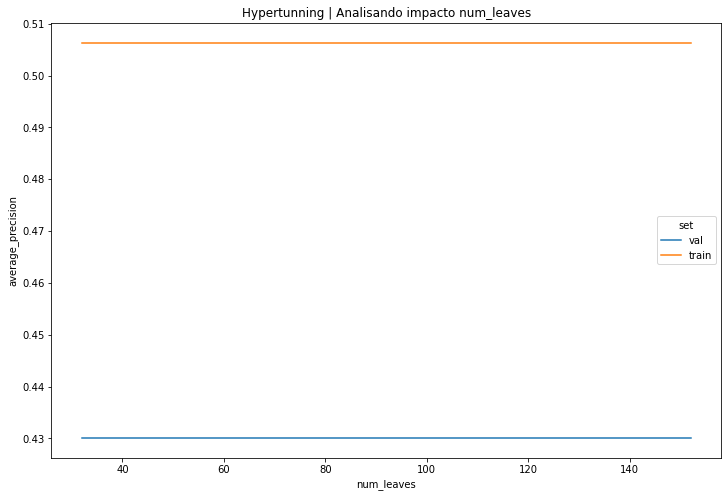

In [17]:
df_plot = training_fased(
    hyper_parameter='num_leaves',
    dict_parameters={
        'n_estimators': 17,
        'max_depth': 3,
        'min_child_samples': 22,
        'learning_rate': 0.15,
        'boosting_type': 'dart',
        'scale_pos_weight': 1.4,
        'class_weight': 'balanced'
    },
    limit_down_range=32,
    limit_up_range=160,
    step=20,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42))
    ]),
    metric=average_precision_score,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

plot_result_metric(
    df_plot=df_plot,
    xlabel='num_leaves',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto num_leaves',
    huer='set'
)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Model Development: Hypertunning</span>
</div>

<br>

In [7]:
for col in [
    'banking_debts', 
    'informed_restriction', 
    'form_completed', 
    'verified_restriction'
]:
    X_train_transformed[col] = X_train_transformed[col].astype('int64')
    X_val_transformed[col] = X_val_transformed[col].astype('int64')
    X_test_transformed[col] = X_test_transformed[col].astype('int64')

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV

pipe_tuning = Pipeline([
    ('transformer_prep', pipe_prep_features),
    ('estimator',LGBMClassifier(random_state=42))
])

cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 42)
metric = 'average_precision'

params = {
    'estimator__n_estimators': [15,16,17,18],
    'estimator__max_depth':[3,4,5,6,7,8,9],
    'estimator__min_child_samples':[22,25,28,35,50],
    'estimator__learning_rate':[0.1,0.11, 0.12, 0.13, 0.14, 0.15],
    'estimator__class_weight':['balanced'],
    # 'estimator__scale_pos_weight': [1.4],
    'estimator__num_leaves':[40],
    'estimator__boosting_type': ['dart']
}

fit_params = {
        'estimator__eval_set':[(X_val_transformed, y_val)],
        'estimator__callbacks':[(early_stopping(stopping_rounds=10, verbose=False))],
        'estimator__eval_metric': metric
}

random_search = RandomizedSearchCV(
    estimator= pipe_tuning,
    param_distributions=params,
    n_iter=200,
    scoring=metric,
    refit=True,
    cv=3,
    random_state=42,
    error_score='raise'
)

random_search.fit(
    X_train_transformed, 
    y_train,
    **fit_params
)

print('####################')
print(random_search.best_score_)
print(random_search.best_params_)

y_pred = random_search.predict_proba(X_val_transformed)[:, 1]
y_pred_train = random_search.predict_proba(X_train_transformed)[:, 1]

####################
0.5112913165783329
{'estimator__num_leaves': 40, 'estimator__n_estimators': 17, 'estimator__min_child_samples': 28, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.14, 'estimator__class_weight': 'balanced', 'estimator__boosting_type': 'dart'}


<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Model Development: Analisando resultados base de validação</span>
</div>

<br>

In [8]:
y_pred_label = random_search.predict(X_train_transformed)
print(classification_report(y_train, y_pred_label))

              precision    recall  f1-score   support

         0.0       0.93      0.71      0.81      7028
         1.0       0.44      0.82      0.57      1957

    accuracy                           0.73      8985
   macro avg       0.69      0.76      0.69      8985
weighted avg       0.83      0.73      0.76      8985



In [9]:
y_pred_label = random_search.predict(X_val_transformed)
print(classification_report(y_val, y_pred_label))

              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77      2343
         1.0       0.38      0.70      0.49       653

    accuracy                           0.69      2996
   macro avg       0.64      0.69      0.63      2996
weighted avg       0.78      0.69      0.71      2996



Você possui 22 features com importância acima de 1.5%
Isso representa 96.0%
Você possui no total 23 features


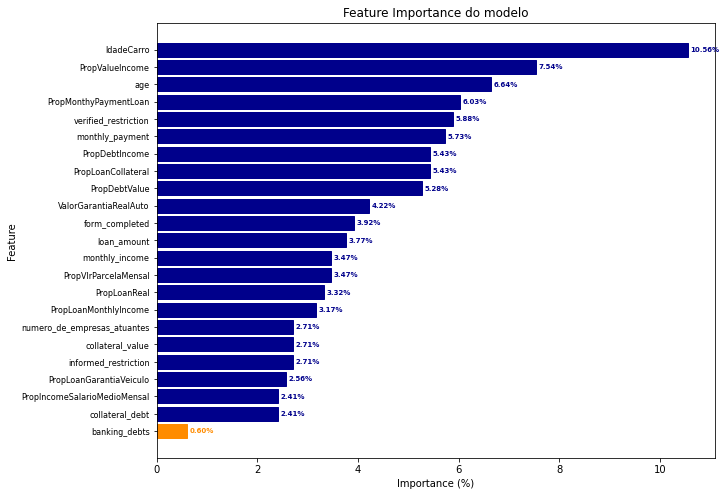

<Figure size 432x288 with 0 Axes>

In [11]:
features = plot_feature_importance(
    model_hyperopt=random_search,
    model_step='estimator',
    preprocessing_step='transformer_prep',
    RFE=False,
    HyperTuner=True

)

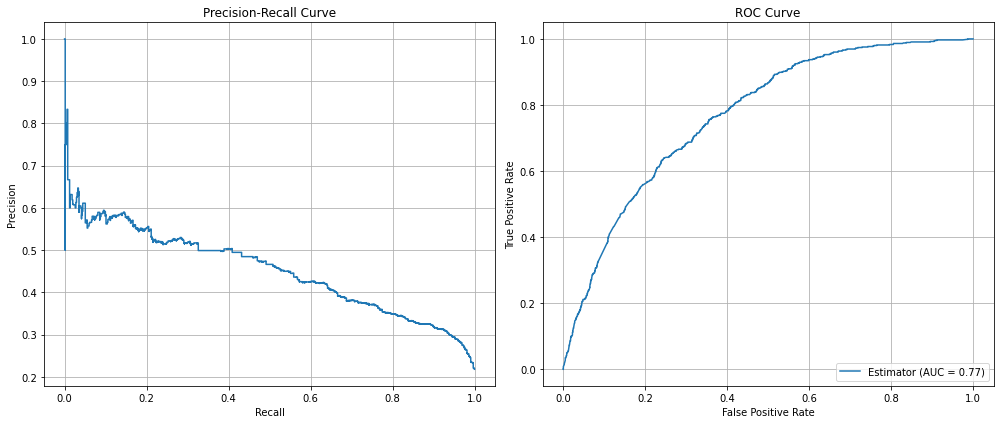

In [12]:
plot_precision_recall_and_roc(
    y_true=y_val, 
    y_pred=y_pred, 
    estimator_name="Estimator"
)

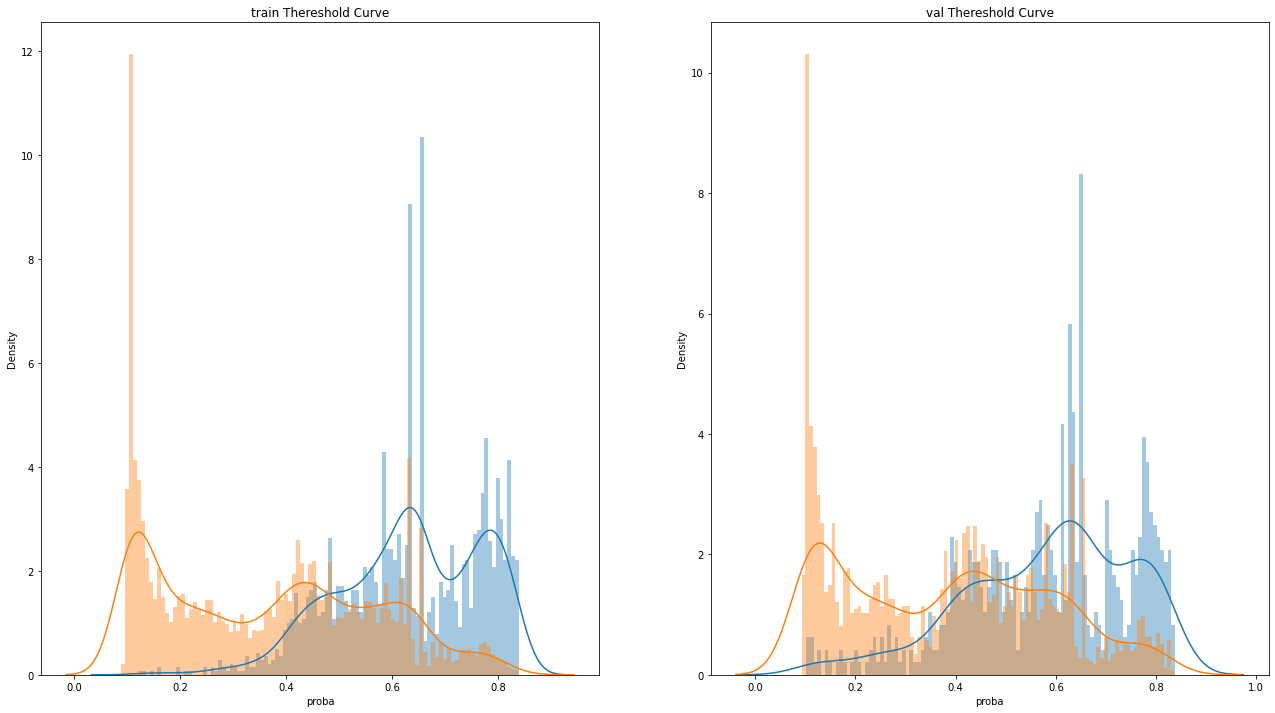

In [69]:
y_pred = random_search.predict_proba(X_val_transformed)[:, 1]
y_pred_train = random_search.predict_proba(X_train_transformed)[:, 1]

plot_dist(
    y_train=y_train,
    pred_proba_train=y_pred_train,
    y_val=y_val,
    pred_proba_val=y_pred
)

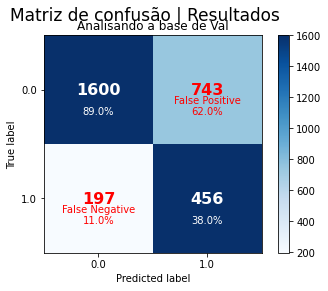

In [9]:
y_pred_label_val = random_search.predict(X_val_transformed)
plot_confusion_matrix(
    y_true=y_val, 
    y_pred=y_pred_label_val, 
    split='Val', 
    position_title=0.475
)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #3AB77A;'>Model Development: Analisando resultados OOS</span>
</div>

<br>

In [13]:
y_pred_label = random_search.predict(X_test_transformed)
print(classification_report(y_test, y_pred_label))

              precision    recall  f1-score   support

         0.0       0.91      0.69      0.78      2343
         1.0       0.40      0.74      0.52       652

    accuracy                           0.70      2995
   macro avg       0.65      0.71      0.65      2995
weighted avg       0.79      0.70      0.72      2995



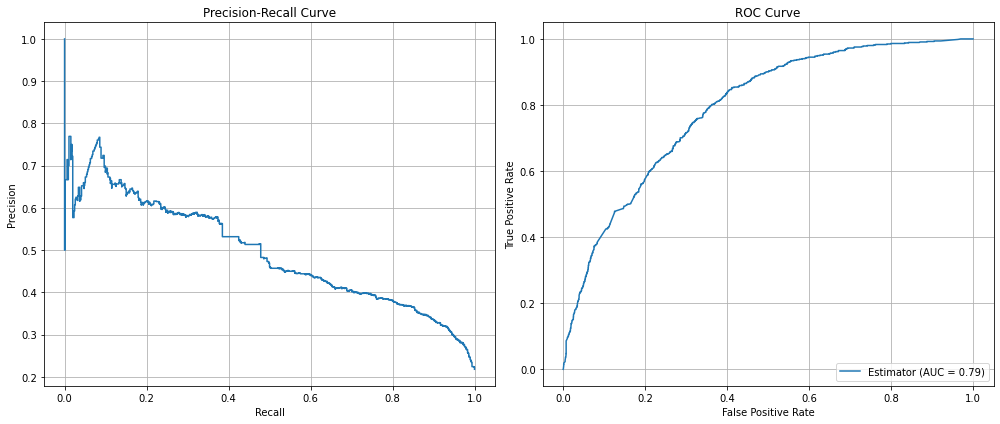

In [14]:
y_pred = random_search.predict_proba(X_test_transformed)[:,1]
plot_precision_recall_and_roc(
    y_true=y_test, 
    y_pred=y_pred, 
    estimator_name="Estimator"
)

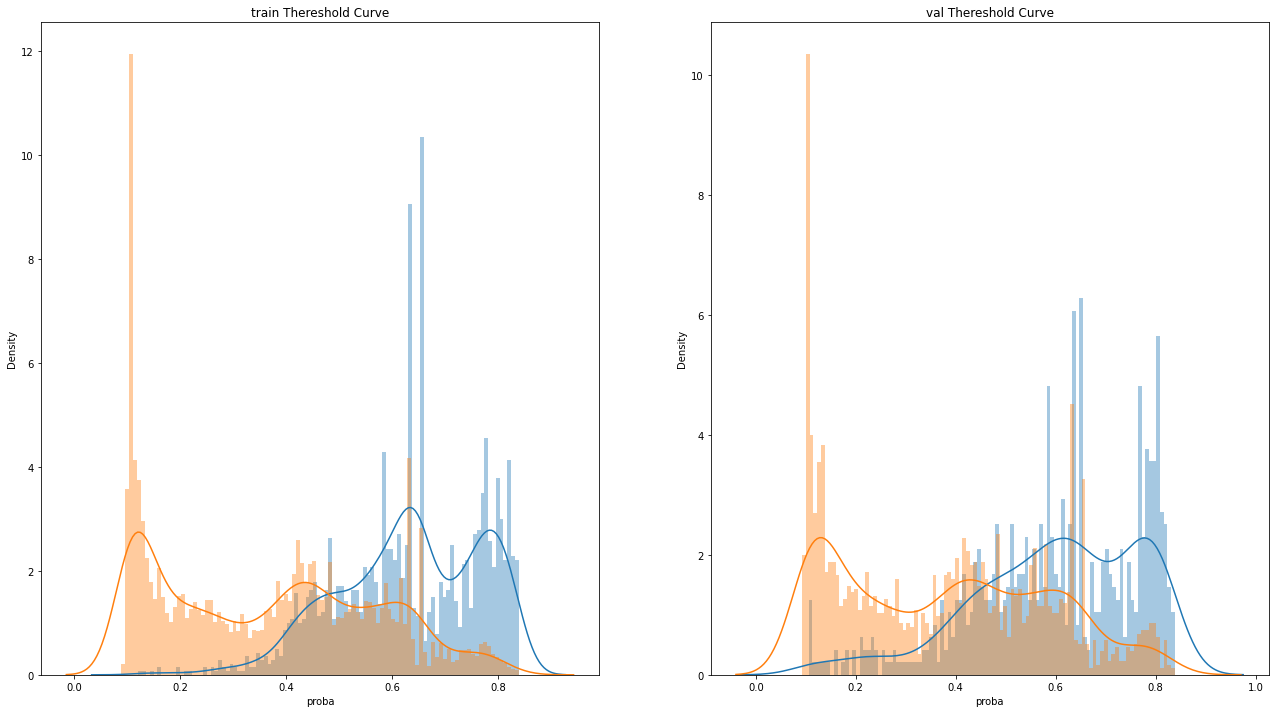

In [72]:
y_pred = random_search.predict_proba(X_test_transformed)[:, 1]
y_pred_train = random_search.predict_proba(X_train_transformed)[:, 1]

plot_dist(
    y_train=y_train,
    pred_proba_train=y_pred_train,
    y_val=y_test,
    pred_proba_val=y_pred
)

########################################################
Usando frac 0.7 para treinamento do shap e beeswarm
Usando o TreeExplainer para o shapley.
########################################################


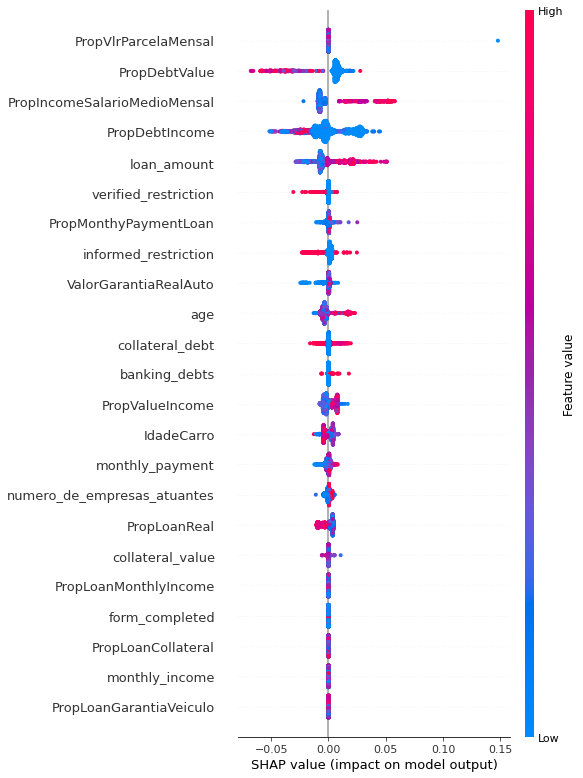

In [10]:
plot_shapley(
    model=random_search.best_estimator_.named_steps['estimator'],
    df=X_test_transformed
)

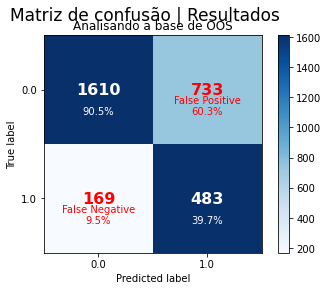

In [10]:
y_pred_label_test = random_search.predict(X_test_transformed)
plot_confusion_matrix(
    y_true=y_test, 
    y_pred=y_pred_label_test, 
    split='OOS', 
    position_title=0.475
)